# Hillfort detection with LiDAR data
## Data management

## Table of contents

[Code](#code)

1. [**Initializing and training the model**](#initializing-and-training-the-model)
2. [**Evaluating the model**](#evaluating-the-model)
3. [**Hyperparameter tuning**](#hyperparameter-tuning)
4. [**Results**](#results)

[End](#end)

## Code

### Defined functions

In [ ]:
!pip install pandas scikit-learn numpy matplotlib laspy tqdm geopandas

In [ ]:
# If you have GPU
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Otherwise
!pip3 install torch torchvision torchaudio

In [21]:
# Imports
# Imports
import os
# import re
# import csv
# import typing
import itertools
# import json
import logging
import zipfile
# import warnings
# import evaluate
# import types
import pandas as pd
import sklearn as sk
import numpy as np
import torch
# import math
import shapely
import matplotlib.pyplot as plt
import laspy # Reading LAS file format
from tqdm import tqdm # Loading bars
import geopandas as gpd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

The model setup has been copied from Nikita Karaev's Google Colab [PointNetClass](https://colab.research.google.com/github/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb#scrollTo=ZV20opgrv23I). Criterion has been customized.

In [22]:
class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [23]:
class PointCloudDataset(Dataset):
    def __init__(self, xyz, labels, num_points=1024):
        self.xyz = xyz
        self.labels = labels
        self.num_points = num_points

    def __len__(self):
        return len(self.xyz)  # Number of point clouds in the dataset

    def __getitem__(self, idx):
        points = self.xyz[idx]  # Points for the idx-th sample
        labels = self.labels[idx]  # Labels for the same sample
        
        # Ensure points is a 2D tensor with shape (N, 3)
        if points.ndimension() == 1:
            points = points.view(-1, 3)

        # Padding to ensure every point cloud has num_points
        if points.shape[0] < self.num_points:
            padding = torch.zeros(self.num_points - points.shape[0], 3)  # Padding with zeros
            points = torch.cat([points, padding], dim=0)  # Concatenate the points with the padding
        else:
            points = points[:self.num_points]  # Truncate if there are more than num_points

        return {'pointcloud': points, 'category': labels}


In [24]:
def pointnetloss(outputs, labels, m3x3, m64x64, criterion, m3x3_weight=0.0001, m64x64_weight=0.0001):
    if not criterion:
        criterion = torch.nn.NLLLoss()
    bs = outputs.size(0)

    # Identity matrices for regularization (to penalize transformation deviations)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1).to(outputs.device)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1).to(outputs.device)

    # Regularization terms
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))

    # Compute the base loss (negative log likelihood)
    base_loss = criterion(outputs, labels)

    # Add regularization (transformation matrices)
    reg_loss = m3x3_weight * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)

    return base_loss + reg_loss

In [25]:
def train(pointnet, criterion, train_loader, device, val_loader=None, epochs=15, save=True):
    optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64, criterion)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            print("Saving model")
            torch.save(pointnet.state_dict(), f=f"../model_weights/save_epoch_{str(epoch)}.pth") # Save the model weights


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
laz_file_dir = '../data/downsampled_class_lazFiles/'

In [16]:
laz_file_dir = '../data/downsampled_class_lazFiles/'

# Step 1: Get the list of LiDAR files
all_files = [os.path.join(laz_file_dir, f) for f in os.listdir(laz_file_dir) if f.endswith('.laz')]

# Step 2: Split the files into train, validation, and test sets
train_files, test_files = sk.model_selection.train_test_split(all_files, test_size=0.2, random_state=42)  # 20% for testing
train_files, val_files = sk.model_selection.train_test_split(train_files, test_size=0.1, random_state=42)  # 10% of train for validation

print(f"Number of files - Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")

# Step 3: Load and group data based on the splits
def load_grouped_data(file_list):
    X, y = [], []
    for file in file_list:
        las = laspy.read(file)
        xyz = las.xyz
        labels = (las.points.array['classification'] == 12).astype(int)  # Hillfort class
        X.append(xyz)
        y.append(labels)
    return X, y

# Load data for each split
X_train, y_train = load_grouped_data(train_files)
X_val, y_val = load_grouped_data(val_files)
X_test, y_test = load_grouped_data(test_files)

# Optionally, combine all points into single arrays for each split
X_train_combined = np.vstack(X_train)
y_train_combined = np.concatenate(y_train)

X_val_combined = np.vstack(X_val)
y_val_combined = np.concatenate(y_val)

X_test_combined = np.vstack(X_test)
y_test_combined = np.concatenate(y_test)

# Print final shapes
print("Train data shape:", X_train_combined.shape, y_train_combined.shape)
print("Validation data shape:", X_val_combined.shape, y_val_combined.shape)
print("Test data shape:", X_test_combined.shape, y_test_combined.shape)


Number of files - Train: 93, Validation: 11, Test: 27
Train data shape: (7141378, 3) (7141378,)
Validation data shape: (731422, 3) (731422,)
Test data shape: (1946003, 3) (1946003,)


In [18]:
print(np.unique(y_train_combined))
print(np.unique(y_val_combined))
print(np.unique(y_test_combined))

[0 1]
[0 1]
[0 1]


In [28]:
class_weights = sk.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_combined), y=y_train_combined)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).cuda() if device.type == "cuda" else torch.tensor(class_weights, dtype=torch.float32)
criterion = torch.nn.NLLLoss(weight=class_weights_tensor)
print(class_weights)

[ 0.5103787  24.58779661]


In [29]:
train_X = torch.from_numpy(X_train_combined)
train_y = torch.from_numpy(y_train_combined).long()
val_X = torch.from_numpy(X_val_combined)
val_y = torch.from_numpy(y_val_combined).long()
test_X = torch.from_numpy(X_test_combined)
test_y = torch.from_numpy(y_test_combined).long()

In [30]:
train_dataset = PointCloudDataset(train_X, train_y)
val_dataset = PointCloudDataset(val_X, val_y)
test_dataset = PointCloudDataset(test_X, test_y)

In [35]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

### Initializing and training the model

In [36]:
pointnet = PointNet(classes=2)
pointnet.to(device);

In [ ]:
train(pointnet, criterion, train_loader, device, val_loader, 1, True)

[Epoch: 1, Batch:   10 / 55793], loss: 0.700
[Epoch: 1, Batch:   20 / 55793], loss: 0.676
[Epoch: 1, Batch:   30 / 55793], loss: 0.770
[Epoch: 1, Batch:   40 / 55793], loss: 0.640
[Epoch: 1, Batch:   50 / 55793], loss: 0.706
[Epoch: 1, Batch:   60 / 55793], loss: 0.664
[Epoch: 1, Batch:   70 / 55793], loss: 0.700
[Epoch: 1, Batch:   80 / 55793], loss: 0.724
[Epoch: 1, Batch:   90 / 55793], loss: 0.597
[Epoch: 1, Batch:  100 / 55793], loss: 0.698
[Epoch: 1, Batch:  110 / 55793], loss: 0.652
[Epoch: 1, Batch:  120 / 55793], loss: 0.608
[Epoch: 1, Batch:  130 / 55793], loss: 0.713
[Epoch: 1, Batch:  140 / 55793], loss: 0.723
[Epoch: 1, Batch:  150 / 55793], loss: 0.703
[Epoch: 1, Batch:  160 / 55793], loss: 0.690
[Epoch: 1, Batch:  170 / 55793], loss: 0.737
[Epoch: 1, Batch:  180 / 55793], loss: 0.652
[Epoch: 1, Batch:  190 / 55793], loss: 0.691
[Epoch: 1, Batch:  200 / 55793], loss: 0.668
[Epoch: 1, Batch:  210 / 55793], loss: 0.677
[Epoch: 1, Batch:  220 / 55793], loss: 0.714
[Epoch: 1,

### Evaluating the model

In [161]:
# Recreate the model architecture
model = PointNet(classes=2)  # Ensure the class arguments are the same as during training

# Load the saved state_dict into the model
model.load_state_dict(torch.load('../model_weights/save_epoch_0.pth'))

# Move the model to the appropriate device and set it to evaluation mode
model.to(device)
model.eval();

C:\Users\Admin\AppData\Local\Temp\ipykernel_8744\2966757700.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../model_weights/save_epoch

In [162]:
all_preds = []
all_labels = []
with torch.no_grad():
    if device.type == "cuda":
        for i, data in enumerate(test_loader):
            if i % 10 == 9:
                print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
            inputs = data['pointcloud'].float().to(device)
            labels = data['category'].to(device)
            outputs, __, __ = pointnet(inputs.transpose(1,2))
            _, preds = torch.max(outputs.data, 1)
            all_preds += list(preds.cpu().numpy())  # Move the tensor to CPU and convert to numpy
            all_labels += list(labels.cpu().numpy())  # Similarly, move labels to CPU
    else:
        for i, data in enumerate(test_loader):
            if i % 10 == 9:
                print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
            inputs, labels = data['pointcloud'].float(), data['category']
            outputs, __, __ = pointnet(inputs.transpose(1,2))
            _, preds = torch.max(outputs.data, 1)
            all_preds += list(preds.numpy())
            all_labels += list(labels.numpy())

Batch [  10 /  698]
Batch [  20 /  698]
Batch [  30 /  698]
Batch [  40 /  698]
Batch [  50 /  698]
Batch [  60 /  698]
Batch [  70 /  698]
Batch [  80 /  698]
Batch [  90 /  698]
Batch [ 100 /  698]
Batch [ 110 /  698]
Batch [ 120 /  698]
Batch [ 130 /  698]
Batch [ 140 /  698]
Batch [ 150 /  698]
Batch [ 160 /  698]
Batch [ 170 /  698]
Batch [ 180 /  698]
Batch [ 190 /  698]
Batch [ 200 /  698]
Batch [ 210 /  698]
Batch [ 220 /  698]
Batch [ 230 /  698]
Batch [ 240 /  698]
Batch [ 250 /  698]
Batch [ 260 /  698]
Batch [ 270 /  698]
Batch [ 280 /  698]
Batch [ 290 /  698]
Batch [ 300 /  698]
Batch [ 310 /  698]
Batch [ 320 /  698]
Batch [ 330 /  698]
Batch [ 340 /  698]
Batch [ 350 /  698]
Batch [ 360 /  698]
Batch [ 370 /  698]
Batch [ 380 /  698]
Batch [ 390 /  698]
Batch [ 400 /  698]
Batch [ 410 /  698]
Batch [ 420 /  698]
Batch [ 430 /  698]
Batch [ 440 /  698]
Batch [ 450 /  698]
Batch [ 460 /  698]
Batch [ 470 /  698]
Batch [ 480 /  698]
Batch [ 490 /  698]
Batch [ 500 /  698]


In [163]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [164]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[78147,  8827],
       [ 2325,     0]], dtype=int64)

In [165]:
classes = {
    0: "Not Hillfort",
    1: "Hillfort"
}

Normalized confusion matrix


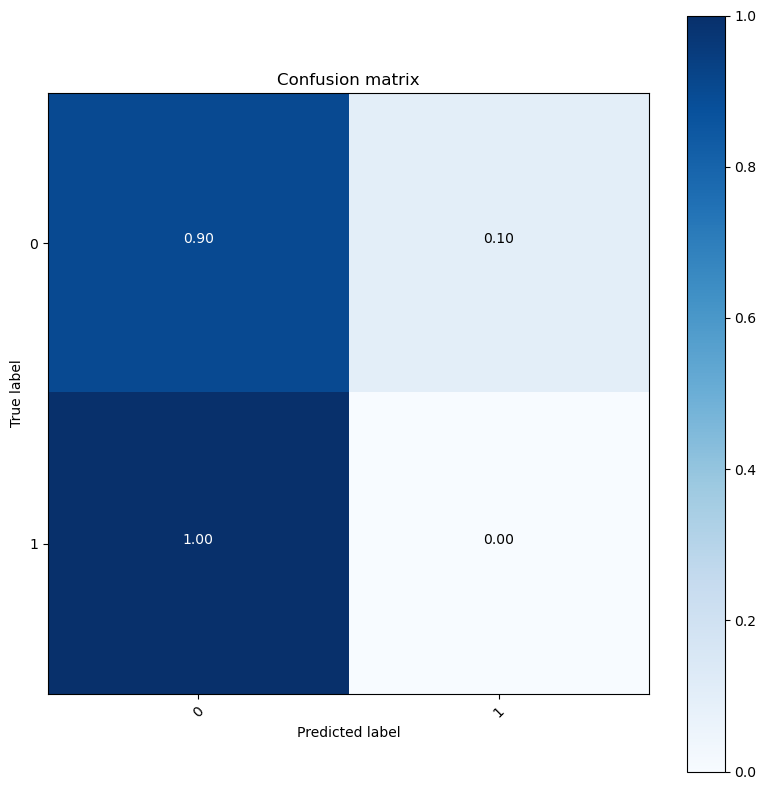

In [166]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


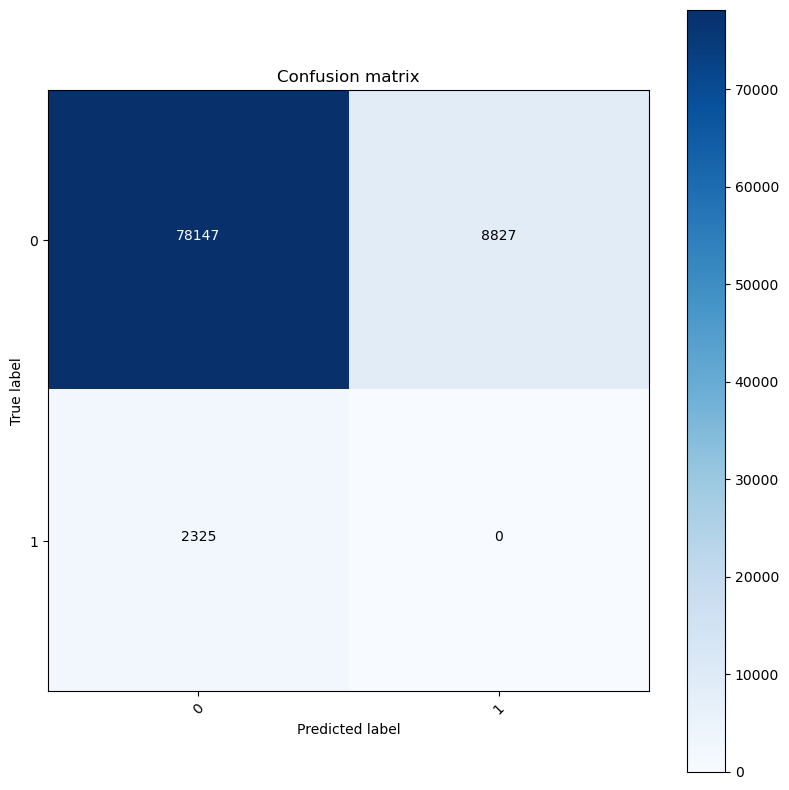

In [167]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

### Hyperparameter tuning

### Results

## End